In [1]:
import torch
from torch import nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.nn.init import zeros_, ones_, constant_
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Make Data

In [ ]:
# dataset
N = 400 # timesteps
S = 64
L = S**2 # spatial domain

## xyt
xs = torch.linspace(-1,1,S)
print(xs)
ys = torch.linspace(-1,1,S)
ts = torch.arange(N)*1.0
t,x,y = torch.meshgrid(ts,xs,ys, indexing="ij")

## equation
cs = torch.cos(t)
ss = torch.sin(t)
sc = 0.25*torch.sin(t/11)+0.75
xuc = x * cs - y * ss
y2 = x * ss + y * cs
x2 = xuc*sc
a = torch.sin(t/2)
b = torch.cos(t/2.1)
f = torch.sin(a*torch.sin(torch.sqrt((x2-0.5)**2+y2**2)*9) + b*torch.cos(torch.sqrt(x2**2+(y2-0.2)**2)*8) + a*b) + x2*t/N - y2**2*t/N

## plot
print(f.shape)
plt.figure(figsize=(100,50))
plt.imshow(f[00:120].reshape(-1,S).T)
plt.show()

##
d = f.reshape((N,L)).T

# Load Data

In [2]:
path = "../../data/CDS_2021_01/data.npz"
d = torch.from_numpy(np.load(path, mmap_mode="r")['input_raw_data'])[:,:,::2,::2] # downsample resolution


In [3]:
N = d.shape[0]
L = d.shape[1] * d.shape[2] * d.shape[3]
print(d.shape)
d = d.reshape((N,L)).T

torch.Size([124, 7, 360, 720])


In [4]:
import gc

def POD(a):
  U,S,Vt = torch.linalg.svd(a,full_matrices=False) # LN
  modes = U # LM
  scale = torch.sum(S**2)
  PVE = S**2 / scale
  return modes, PVE.numpy(), scale

def POD_break(a,steps=10,acc=0.99):
  items = []
  for i in range(steps):
    ai = a[:,i*steps:(i+1)*steps]
    U,S,Vt = torch.linalg.svd(ai,full_matrices=False)

    eig = S**2

    PVE = torch.cumsum(eig[1:], dim=0) / torch.sum(eig[1:]) # make sure to skip mean
    try:
      q = min(torch.where(PVE > acc)[0][0] + 1, len(eig))
    except IndexError:
      q = 1 # first is sufficient

    # print(q, PVE[q])


    # print(U.shape, S.shape)
    items.append(U[:,:q]@torch.diag(S[:q])) # LM MM

  data = torch.cat(items, dim=1)
  U,S,Vt = torch.linalg.svd(data,full_matrices=False)

  modes = U
  gc.collect()
  return modes

def PVE(a, modes, scale):
  # assumes orth. modes
  al = modes.T @ a# a@a.T expected to be QLQt # LL
  L = al @ al.T # expected to be diagonal with upper matrices having trace = cum PVE

  # in case not diagonal do eigendecomp:
  PVE = torch.flip(torch.linalg.eigvalsh(L),dims=(0,)) / scale

  isolated_PVE = torch.diagonal(L,0) / scale

  return isolated_PVE.numpy(), PVE.numpy()





100%|██████████| 4/4 [00:22<00:00,  5.66s/it]


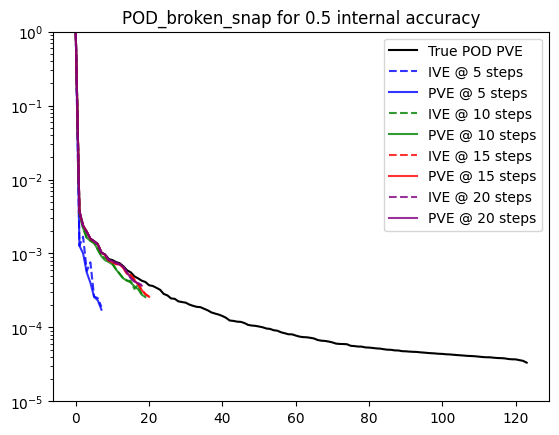

100%|██████████| 4/4 [00:22<00:00,  5.52s/it]


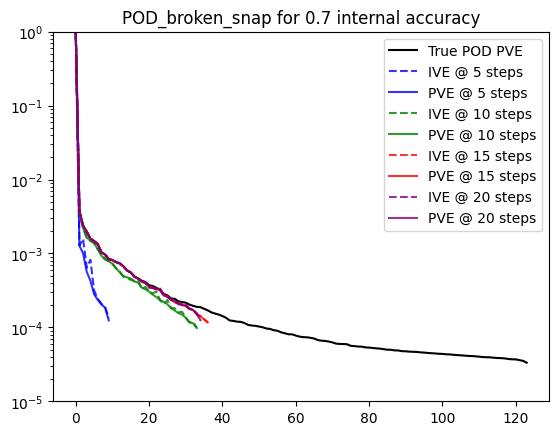

100%|██████████| 4/4 [00:37<00:00,  9.38s/it]


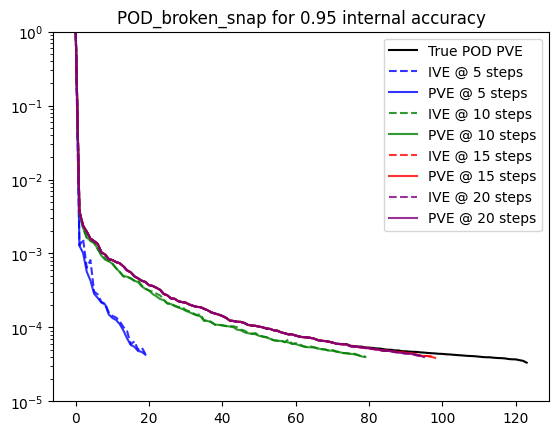

100%|██████████| 4/4 [00:41<00:00, 10.48s/it]


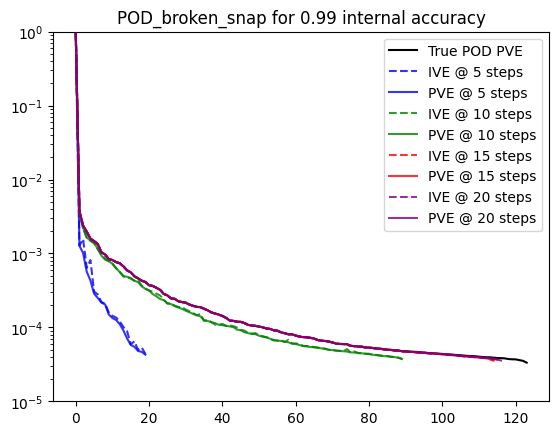

In [20]:
_, pve0, scale = POD(d)
steps = [5, 10, 15, 20]
colors = ['blue','green','red','purple']

for acc in [0.5, 0.7, 0.95, 0.99]:
  plt.Figure(figsize=(10,10))
  plt.plot(pve0, color='black', linestyle='-', label=f"True POD PVE")
  data = [POD_break(d,steps=s,acc=acc) for s in tqdm(steps)]
  labels = [f'@ {s} steps' for s in steps]
  mode = ['-','--']
  alpha = 0.8
  for i,di in enumerate(data):
    ive, pve = PVE(d, di, scale)
    plt.plot(ive, color=colors[i], linestyle=mode[1], label=f"IVE {labels[i]}", alpha=0.8)
    plt.plot(pve, color=colors[i], linestyle=mode[0], label=f"PVE {labels[i]}", alpha=0.8)
  plt.yscale('log')
  # plt.xscale('log')
  
  plt.ylim(0.00001,1.0)
  plt.legend()
  plt.title(f"POD_broken_snap for {acc} internal accuracy")
  plt.show()
  plt.close()